In [1]:
import requests
from bs4 import BeautifulSoup
import functools
from function_pipes import pipe
import numpy as np
import networkx as nx
import copy
import matplotlib
from pprint import pprint
import pandas as pd
import collections

/tmp/ipykernel_93486/1716046150.py:10: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


Grabbing Webpage

In [2]:
url = "https://masteringruneterra.com/mu-table/"
page = requests.get(url)

soup = BeautifulSoup(page.content, 'html.parser')

Doing finding and stuff

In [13]:
headers = soup.select("div.grid-item:not(.versus-cell)")
headers = map(lambda x: x.text.strip(), headers)
decks = list(headers)[1:16]
print(len(decks))
print(decks)

15
['Annie Jhin (NX/RU)', 'Gwen Zed (IO/SI)', 'Elder Dragon Mordekaiser Viego (RU/SI)', "Pyke Rek'Sai (BW/SH)", 'Elder Dragon Galio Morgana (DE/RU)', 'Caitlyn Teemo (FR/PZ)', 'Elder Dragon Volibear (FR/RU)', 'Ashe LeBlanc (FR/NX)', 'Aurelion Sol Elder Dragon (MT/RU)', 'Master Yi Nami (BW/IO)', 'Karma Sett (IO/PZ)', 'Elder Dragon Morgana Shyvana (DE/RU)', 'Janna Nilah (BW/PZ)', 'Karma Sett (FR/IO)', 'Maokai Nautilus (BW/SI)']


In [4]:
cells = soup.select(".versus-cell > div")
rawText = map(lambda x: x.text.strip(), cells)
def getWinRateAndGames(text):
    winRate, games = text.split("\n");
    #handing winrate
    winRate = winRate[:-1]#dropping %
    winRate = float(winRate)
    winRate = winRate / 100
    winRate = round(winRate, 4)
    
    #handling games
    games = games.split(" ")[1]
    games = int(games)
    return {"winRate": winRate, "gamesPlayed": games}
matchUps = list(map(getWinRateAndGames, rawText))
matchUps[0:10]



[{'winRate': 0.6152, 'gamesPlayed': 473},
 {'winRate': 0.6344, 'gamesPlayed': 413},
 {'winRate': 0.5553, 'gamesPlayed': 425},
 {'winRate': 0.5, 'gamesPlayed': 292},
 {'winRate': 0.7401, 'gamesPlayed': 227},
 {'winRate': 0.77, 'gamesPlayed': 213},
 {'winRate': 0.6032, 'gamesPlayed': 252},
 {'winRate': 0.641, 'gamesPlayed': 234},
 {'winRate': 0.6146, 'gamesPlayed': 192},
 {'winRate': 0.4709, 'gamesPlayed': 206}]

Converting to a table

In [5]:
table = {key: {} for key in decks}
muIndex = 0
for rawIndex in range(len(decks) * len(decks)):
    i = rawIndex // 15
    j = rawIndex % 15
    deck1 = decks[i]
    deck2 = decks[j]
    if i == j: #diagonal on the match up, the deck is playing itself
        table[deck1][deck2] = {"winRate": 0.5, "gamesPlayed": 10000}
        continue
    mu = matchUps[muIndex]
    muIndex += 1
    table[deck1][deck2] = {"winRate": mu["winRate"], "gamesPlayed": mu["gamesPlayed"]}
print(table)

{'Annie Jhin (NX/RU)': {'Annie Jhin (NX/RU)': {'winRate': 0.5, 'gamesPlayed': 10000}, 'Gwen Zed (IO/SI)': {'winRate': 0.6152, 'gamesPlayed': 473}, 'Elder Dragon Mordekaiser Viego (RU/SI)': {'winRate': 0.6344, 'gamesPlayed': 413}, "Pyke Rek'Sai (BW/SH)": {'winRate': 0.5553, 'gamesPlayed': 425}, 'Elder Dragon Galio Morgana (DE/RU)': {'winRate': 0.5, 'gamesPlayed': 292}, 'Caitlyn Teemo (FR/PZ)': {'winRate': 0.7401, 'gamesPlayed': 227}, 'Elder Dragon Volibear (FR/RU)': {'winRate': 0.77, 'gamesPlayed': 213}, 'Ashe LeBlanc (FR/NX)': {'winRate': 0.6032, 'gamesPlayed': 252}, 'Aurelion Sol Elder Dragon (MT/RU)': {'winRate': 0.641, 'gamesPlayed': 234}, 'Master Yi Nami (BW/IO)': {'winRate': 0.6146, 'gamesPlayed': 192}, 'Karma Sett (IO/PZ)': {'winRate': 0.4709, 'gamesPlayed': 206}, 'Elder Dragon Morgana Shyvana (DE/RU)': {'winRate': 0.3898, 'gamesPlayed': 177}, 'Janna Nilah (BW/PZ)': {'winRate': 0.3011, 'gamesPlayed': 186}, 'Karma Sett (FR/IO)': {'winRate': 0.7423, 'gamesPlayed': 163}, 'Maokai Nau

Creating Network from it


In [6]:
#changing it so the weights are the winrate

def getWinRate(item):
    return item["winRate"]

def onlyGoodMUs(item):
    winRate = getWinRate(item)
    if winRate > 0.55:
        return winRate
    return False

def convertGraph(table, converter):
    clonedTable = copy.deepcopy(table)
    for key, value in clonedTable.items():
        newDict = {}
        for key2, value2 in value.items():
            newValue = converter(value2)
            if newValue:
                newDict[key2] = {"weight": newValue}
        clonedTable[key] = newDict
    return clonedTable
winRateTable = convertGraph(table, getWinRate)
goodWinRates = convertGraph(table, onlyGoodMUs)
pprint(winRateTable)

{'Annie Jhin (NX/RU)': {'Annie Jhin (NX/RU)': {'weight': 0.5},
                        'Ashe LeBlanc (FR/NX)': {'weight': 0.6032},
                        'Aurelion Sol Elder Dragon (MT/RU)': {'weight': 0.641},
                        'Caitlyn Teemo (FR/PZ)': {'weight': 0.7401},
                        'Elder Dragon Galio Morgana (DE/RU)': {'weight': 0.5},
                        'Elder Dragon Mordekaiser Viego (RU/SI)': {'weight': 0.6344},
                        'Elder Dragon Morgana Shyvana (DE/RU)': {'weight': 0.3898},
                        'Elder Dragon Volibear (FR/RU)': {'weight': 0.77},
                        'Gwen Zed (IO/SI)': {'weight': 0.6152},
                        'Janna Nilah (BW/PZ)': {'weight': 0.3011},
                        'Karma Sett (FR/IO)': {'weight': 0.7423},
                        'Karma Sett (IO/PZ)': {'weight': 0.4709},
                        'Maokai Nautilus (BW/SI)': {'weight': 0.5515},
                        'Master Yi Nami (BW/IO)': {'weight': 0

In [7]:
G = nx.from_dict_of_dicts(winRateTable)
G

Writing to file

In [8]:
nx.write_graphml(G, "data/mu.graphml")

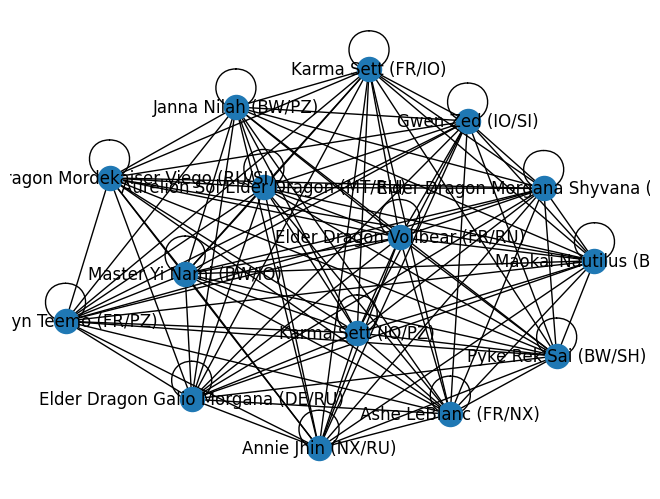

In [9]:
nx.draw(G, with_labels=True)

Graphing only good winrates

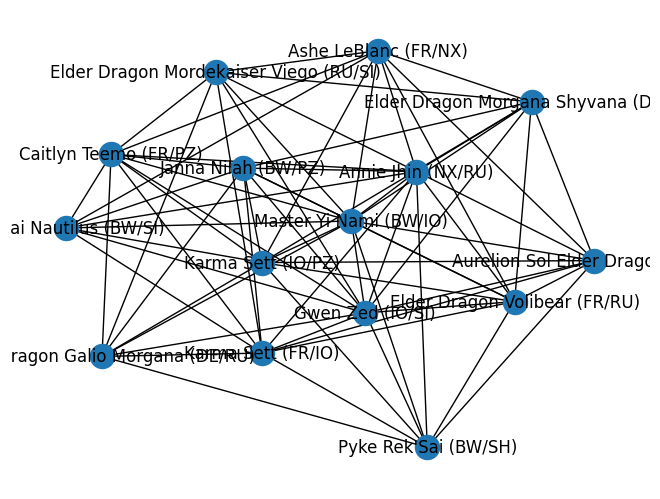

In [10]:
goodG = nx.from_dict_of_dicts(goodWinRates)
nx.draw(goodG, with_labels=True)

Translating to pandas

In [11]:
def toPandasDict(table, getter):
    newTable = {}
    for key, value in table.items():
        otherDecks = value.values()  
        newValues = pipe(map(getter, otherDecks), list)
        newTable[key] = newValues
    newTable["decks"] = decks
    return newTable
def toDf(table, getter):
    translatedTable = toPandasDict(table, getter)
    df = pd.DataFrame.from_dict(translatedTable).set_index("decks").T
    return df
    
winDF = toDf(table, getWinRate)
playRateDF = toDf(table, lambda x: x["gamesPlayed"])
display(winDF)
display(playRateDF)


decks,Annie Jhin (NX/RU),Gwen Zed (IO/SI),Elder Dragon Mordekaiser Viego (RU/SI),Pyke Rek'Sai (BW/SH),Elder Dragon Galio Morgana (DE/RU),Caitlyn Teemo (FR/PZ),Elder Dragon Volibear (FR/RU),Ashe LeBlanc (FR/NX),Aurelion Sol Elder Dragon (MT/RU),Master Yi Nami (BW/IO),Karma Sett (IO/PZ),Elder Dragon Morgana Shyvana (DE/RU),Janna Nilah (BW/PZ),Karma Sett (FR/IO),Maokai Nautilus (BW/SI)
Annie Jhin (NX/RU),0.5000,0.6152,0.6344,0.5553,0.5000,0.7401,0.7700,0.6032,0.6410,0.6146,0.4709,0.3898,0.3011,0.7423,0.5515
Gwen Zed (IO/SI),0.3848,0.5000,0.6562,0.6675,0.5714,0.6434,0.7990,0.5276,0.6585,0.5822,0.4815,0.4110,0.4438,0.7302,0.5556
Elder Dragon Mordekaiser Viego (RU/SI),0.3656,0.3438,0.5000,0.4887,0.5913,0.3364,0.4901,0.6098,0.5163,0.3039,0.4554,0.5838,0.4857,0.3200,0.4901
Pyke Rek'Sai (BW/SH),0.4447,0.3325,0.5113,0.5000,0.6163,0.5407,0.6966,0.4921,0.6182,0.6303,0.5556,0.5411,0.4880,0.6000,0.5259
Elder Dragon Galio Morgana (DE/RU),0.5000,0.4286,0.4087,0.3837,0.5000,0.6992,0.5368,0.4836,0.5166,0.6423,0.5849,0.5463,0.6598,0.5579,0.5402
Caitlyn Teemo (FR/PZ),0.2555,0.3566,0.6636,0.4545,0.3008,0.5000,0.5464,0.4216,0.5333,0.4056,0.7412,0.5000,0.7927,0.7241,0.6620
Elder Dragon Volibear (FR/RU),0.2300,0.2010,0.5099,0.3034,0.4632,0.4536,0.5000,0.3976,0.6746,0.4245,0.5889,0.6757,0.4000,0.3370,0.5256
Ashe LeBlanc (FR/NX),0.3968,0.4724,0.3902,0.5079,0.5164,0.5784,0.6024,0.5000,0.6413,0.6087,0.5963,0.6064,0.5000,0.4907,0.6316
Aurelion Sol Elder Dragon (MT/RU),0.3590,0.3415,0.4837,0.3818,0.4834,0.4667,0.3254,0.3587,0.5000,0.4135,0.4464,0.4412,0.4578,0.1667,0.4853
Master Yi Nami (BW/IO),0.3854,0.4178,0.6961,0.3697,0.3577,0.5944,0.5755,0.3913,0.5865,0.5000,0.4271,0.3535,0.2791,0.4884,0.6351


decks,Annie Jhin (NX/RU),Gwen Zed (IO/SI),Elder Dragon Mordekaiser Viego (RU/SI),Pyke Rek'Sai (BW/SH),Elder Dragon Galio Morgana (DE/RU),Caitlyn Teemo (FR/PZ),Elder Dragon Volibear (FR/RU),Ashe LeBlanc (FR/NX),Aurelion Sol Elder Dragon (MT/RU),Master Yi Nami (BW/IO),Karma Sett (IO/PZ),Elder Dragon Morgana Shyvana (DE/RU),Janna Nilah (BW/PZ),Karma Sett (FR/IO),Maokai Nautilus (BW/SI)
Annie Jhin (NX/RU),10000,473,413,425,292,227,213,252,234,192,206,177,186,163,165
Gwen Zed (IO/SI),473,10000,381,388,308,258,199,254,205,225,189,163,169,189,126
Elder Dragon Mordekaiser Viego (RU/SI),413,381,10000,354,252,220,202,205,184,204,202,173,175,150,151
Pyke Rek'Sai (BW/SH),425,388,354,10000,258,209,145,191,165,165,162,146,125,145,116
Elder Dragon Galio Morgana (DE/RU),292,308,252,258,10000,123,136,122,151,123,106,108,97,95,87
Caitlyn Teemo (FR/PZ),227,258,220,209,123,10000,97,102,75,143,85,96,82,87,71
Elder Dragon Volibear (FR/RU),213,199,202,145,136,97,10000,83,126,106,90,74,75,92,78
Ashe LeBlanc (FR/NX),252,254,205,191,122,102,83,10000,92,115,109,94,90,108,76
Aurelion Sol Elder Dragon (MT/RU),234,205,184,165,151,75,126,92,10000,104,112,68,83,78,68
Master Yi Nami (BW/IO),192,225,204,165,123,143,106,115,104,10000,96,99,86,86,74


Getting best preforming decks

In [12]:
def getMetaCounters(winDF: pd.DataFrame, numMetaDecks=15, numDecksToReturn = 5):
    
    # get the expected winrate against each n meta decks
    metaDecks = winDF.iloc[:, :numMetaDecks + 1] 
   
    # get the expected winrate by averaging that
    expectedWinRates = metaDecks.mean(axis=1)
    
    # return the highest n ones
    sortedDecks = expectedWinRates.sort_values(ascending=False)[0:numDecksToReturn + 1]
    
    #add the winrates against each of the metadecks
    df = pd.DataFrame(sortedDecks, columns=["expected winrate"])
    
    matchUps = winDF.loc[sortedDecks.keys()]
    df = df.join(matchUps) #adding winrates against each meta deck
    return df

getMetaCounters(winDF)

,expected winrate,Annie Jhin (NX/RU),Gwen Zed (IO/SI),Elder Dragon Mordekaiser Viego (RU/SI),Pyke Rek'Sai (BW/SH),Elder Dragon Galio Morgana (DE/RU),Caitlyn Teemo (FR/PZ),Elder Dragon Volibear (FR/RU),Ashe LeBlanc (FR/NX),Aurelion Sol Elder Dragon (MT/RU),Master Yi Nami (BW/IO),Karma Sett (IO/PZ),Elder Dragon Morgana Shyvana (DE/RU),Janna Nilah (BW/PZ),Karma Sett (FR/IO),Maokai Nautilus (BW/SI)
Annie Jhin (NX/RU),0.575293,0.5000,0.6152,0.6344,0.5553,0.5000,0.7401,0.7700,0.6032,0.6410,0.6146,0.4709,0.3898,0.3011,0.7423,0.5515
Gwen Zed (IO/SI),0.574180,0.3848,0.5000,0.6562,0.6675,0.5714,0.6434,0.7990,0.5276,0.6585,0.5822,0.4815,0.4110,0.4438,0.7302,0.5556
Pyke Rek'Sai (BW/SH),0.539553,0.4447,0.3325,0.5113,0.5000,0.6163,0.5407,0.6966,0.4921,0.6182,0.6303,0.5556,0.5411,0.4880,0.6000,0.5259
Ashe LeBlanc (FR/NX),0.535967,0.3968,0.4724,0.3902,0.5079,0.5164,0.5784,0.6024,0.5000,0.6413,0.6087,0.5963,0.6064,0.5000,0.4907,0.6316
Elder Dragon Galio Morgana (DE/RU),0.532573,0.5000,0.4286,0.4087,0.3837,0.5000,0.6992,0.5368,0.4836,0.5166,0.6423,0.5849,0.5463,0.6598,0.5579,0.5402
Elder Dragon Morgana Shyvana (DE/RU),0.525753,0.6102,0.5890,0.4162,0.4589,0.4537,0.5000,0.3243,0.3936,0.5588,0.6465,0.6154,0.5000,0.7742,0.5000,0.5455
